In [1]:
import torch
from torch import Tensor
from torch import nn 
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from utility import *

np.random.seed(seed=7)

In [2]:
import dlc_bci

train_input_100 , train_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False)
test_input_100 , test_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False, train = False)

train_input_1000 , train_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, one_khz = True)
test_input_1000 , test_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, train = False, one_khz = True)

print("Train input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_100.size())))
print("Train target 100 Hz: {:d}".format(*(s for s in train_target_100.size())))
print("Test input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_100.size())))
print("Test target 100 Hz: {:d}".format(*(s for s in test_target_100.size())))
print("")
print("Train input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_1000.size())))
print("Train target 1000 Hz: {:d}".format(*(s for s in train_target_1000.size())))
print("Test input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_1000.size())))
print("Test target 1000 Hz: {:d}".format(*(s for s in test_target_1000.size())))

Train input 100 Hz: 316x28x50
Train target 100 Hz: 316
Test input 100 Hz: 100x28x50
Test target 100 Hz: 100

Train input 1000 Hz: 316x28x500
Train target 1000 Hz: 316
Test input 1000 Hz: 100x28x500
Test target 1000 Hz: 100


# Network definition

This conv2d network is more inspired from a classic conv2d net that is used for image recognition 

In [3]:
from models import *

# Preprocessing and Data Augmentation

In [4]:
import numpy as np

preprocessed_input_train, preprocessed_input_validation, preprocessed_input_train_target, preprocessed_input_validation_target, kept_channels_idx = preprocessing_train(train_input_1000, train_target_1000, subsampling_frequency='100Hz', window=False,denoize=False, addGaussianNoise=False, reduceChannels=False, cutEnd = False)
preprocessed_input_test, preprocessed_input_test_target  = preprocessing_test(test_input_1000, test_target_1000, kept_channels_idx, subsampling_frequency='100Hz', window=False,denoize = False, reduceChannels=False, cutEnd=False)

#Remove Noise
#preprocessed_input_train = denoisedSignals(preprocessed_input_train)
#preprocessed_input_validation = denoisedSignals(preprocessed_input_validation)
#preprocessed_input_test = denoisedSignals(preprocessed_input_test)
#add random noise
#preprocessed_input_train = whiteNoise(preprocessed_input_train)
#preprocessed_input_validation = whiteNoise(preprocessed_input_validation)
#preprocessed_input_test = whiteNoise(preprocessed_input_test)

print('train', preprocessed_input_train.shape)
print('test', preprocessed_input_test.shape)
print('validation', preprocessed_input_validation.shape)

labels_train = torch.from_numpy(preprocessed_input_train_target)
labels_test = torch.from_numpy(preprocessed_input_test_target)
labels_validation = torch.from_numpy(preprocessed_input_validation_target)

preprocessed_input_train = torch.from_numpy(preprocessed_input_train).float()
preprocessed_input_test = torch.from_numpy(preprocessed_input_test).float()
preprocessed_input_validation = torch.from_numpy(preprocessed_input_validation).float()

Ntrain = len(preprocessed_input_train[:,0,0])
Ntest = len(preprocessed_input_test[:,0,0])
Nvalidation = len(preprocessed_input_validation[:,0,0])

Nchannels = len(preprocessed_input_train[0,:,0])
Nsamples_100 = preprocessed_input_train.size(-1)

print('Ntrain = ', Ntrain)
print('Ntest = ', Ntest)
print('Nvalidation = ', Nvalidation)

train_input = Variable(preprocessed_input_train.view(Ntrain, 1, Nchannels, Nsamples_100))
validation_input = Variable(preprocessed_input_validation.view(Nvalidation, 1, Nchannels, Nsamples_100), requires_grad=False)
test_input = Variable(preprocessed_input_test.contiguous().view(Ntest, 1, Nchannels, Nsamples_100), requires_grad=False)

train (3000, 28, 50)
test (1000, 28, 50)
validation (160, 28, 50)
Ntrain =  3000
Ntest =  1000
Nvalidation =  160


# Network training and testing
Non-linearity: elu  


|criterion | optimizer | lr  | momentum | batch size | Nepochs | Train acc. | Test acc.|
|----------|-----------|-----|----------|------------|---------|------------|----------|
| BCE  | Adam  |1e-1 | def. | 15 | 150 | 86.4 | 61.4 | 
| BCE  | Adam  |1e-1 | def. | 20 | 150 | 99.8 | 79.5 | 
| BCE  | SGD   | 1e-2 | 0.85 | 20 | 150 | 98.9  | 61.5 | 
| CE   | Adam  | 1e-2 | def. | 20 | 150 | 98.4  |  70.5 | 
| CE   | SGD   | 1e-2 | 0.85 | 20 | 150 | 99.1 | 75.1 |


Non-linearity: ReLU

In [5]:
import torch.optim as optim
import math

# Train network 
#criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()
#criterion = nn.PoissonNLLLoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.SmoothL1Loss() #interesting ... but does not converge
#criterion = nn.MSELoss() #0.83 but unstable

if isinstance(criterion, nn.CrossEntropyLoss):
    train_target = Variable(labels_train)  # keep long tensors
    validation_target = Variable(labels_validation, requires_grad=False) # convert to float
    test_target = Variable(labels_test, requires_grad=False)
    Noutputs = 2
    
elif isinstance(criterion, nn.NLLLoss):
    train_target = Variable(labels_train)  # keep long tensors
    validation_target = Variable(labels_validation, requires_grad=False) # convert to float
    test_target = Variable(labels_test, requires_grad=False )
    Noutputs = 2
    
else:
    train_target = Variable(labels_train.float()) # convert to float
    validation_target = Variable(labels_validation.float(), requires_grad=False) # convert to float
    test_target = Variable(labels_test.float(), requires_grad=False)
    Noutputs = 1

batch_size = 15
Nbatches = int(math.ceil(Ntrain/batch_size))
Nepochs = 100
seeds = list(range(10))
#seeds = [14,20,21,22,27,46,44,37,31,28]
Nrep = len(seeds)

train_errors = torch.Tensor(Nrep, Nepochs).zero_()
test_errors = torch.Tensor(Nrep, Nepochs).zero_()
validation_errors = torch.Tensor(Nrep, Nepochs).zero_()
ep_loss = torch.Tensor(Nrep, Nepochs).zero_()

for i_rep in range(Nrep):
    
    print('Repetition', seeds[i_rep])
    torch.manual_seed(seeds[i_rep])
    #model = conv2DNet_1(Noutputs) #from classic knowledge of image segmentation  
    #model = conv2DNet_2(Nchannels, Nsamples_100, Noutputs) #from litterature 
    #model = conv2DNet_3(Noutputs) #from PdM
    #model = conv2DNet_4(Noutputs) #from PdM
    #model = conv2DNet_5(Noutputs)
    #model = conv2DNet_6(Noutputs)
    #model = conv2DNet_7(Noutputs)
    model = conv2DNet_9(Noutputs)
    
    optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.50)
    #optimizer = optim.Adam(model.parameters())
    #optimizer = optim.Adagrad(model.parameters())
    #optimizer = optim.Adamax(model.parameters())
    #optimizer = optim.ASGD(model.parameters())
    #optimizer = optim.RMSprop(model.parameters())
    #optimizer = optim.Rprop(model.parameters())
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

    for i_ep in range(Nepochs):
        for b_start in range(0, Ntrain, batch_size):
            bsize_eff = batch_size - max(0, b_start+batch_size-Ntrain)  # boundary case
            model.train()
            model.zero_grad()
            output = model.forward(train_input.narrow(0, b_start, bsize_eff))
            if isinstance(criterion, nn.CrossEntropyLoss) or isinstance(criterion, nn.NLLLoss):
                batch_loss = criterion(output, train_target.narrow(0, b_start, bsize_eff))  
            else: 
                batch_loss = criterion(output.view(bsize_eff), train_target.narrow(0, b_start, bsize_eff))           
            ep_loss[i_rep, i_ep] += batch_loss.data[0]
            batch_loss.backward()
            optimizer.step()
        
        scheduler.step(ep_loss[i_rep, i_ep])
        
        nb_train_errs = compute_nb_errors(model, train_input, train_target, batch_size, criterion)
        nb_validation_errs = compute_nb_errors(model, validation_input, validation_target, batch_size, criterion)
        nb_test_errs = compute_nb_errors(model, test_input, test_target, batch_size, criterion)
        
        print("Epoch Number : ", i_ep)
        print("\t Training accuracy: ", (100*(Ntrain-nb_train_errs)/Ntrain))
        print("\t Validation accuracy ",(100*(Nvalidation-nb_validation_errs)/Nvalidation)) 
        print("\t Test accuracy ",(100*(Ntest-nb_test_errs)/Ntest))
        
        print("\t Epoch Loss ", ep_loss[i_rep, i_ep])
        
        train_errors[i_rep, i_ep] = nb_train_errs
        test_errors[i_rep, i_ep] = nb_test_errs
        validation_errors[i_rep, i_ep] = nb_validation_errs

Repetition 0
Epoch Number :  0
	 Training accuracy:  50.2
	 Validation accuracy  37.5
	 Test accuracy  49.2
	 Epoch Loss  138.74827575683594
Epoch Number :  1
	 Training accuracy:  50.166666666666664
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  138.9326629638672
Epoch Number :  2
	 Training accuracy:  50.333333333333336
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  138.6744384765625
Epoch Number :  3
	 Training accuracy:  50.56666666666667
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  138.7305450439453
Epoch Number :  4
	 Training accuracy:  50.5
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  138.82989501953125
Epoch Number :  5
	 Training accuracy:  50.666666666666664
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  138.66860961914062
Epoch Number :  6
	 Training accuracy:  50.86666666666667
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  138.76107788085938
Epoch Number :  7
	 Traini

Epoch Number :  60
	 Training accuracy:  73.7
	 Validation accuracy  43.75
	 Test accuracy  60.5
	 Epoch Loss  130.2286834716797
Epoch Number :  61
	 Training accuracy:  74.93333333333334
	 Validation accuracy  39.375
	 Test accuracy  61.8
	 Epoch Loss  129.9520263671875
Epoch Number :  62
	 Training accuracy:  74.36666666666666
	 Validation accuracy  31.25
	 Test accuracy  60.7
	 Epoch Loss  129.42189025878906
Epoch Number :  63
	 Training accuracy:  74.5
	 Validation accuracy  36.25
	 Test accuracy  62.3
	 Epoch Loss  128.31228637695312
Epoch Number :  64
	 Training accuracy:  75.1
	 Validation accuracy  43.75
	 Test accuracy  63.6
	 Epoch Loss  127.94898986816406
Epoch Number :  65
	 Training accuracy:  75.93333333333334
	 Validation accuracy  43.75
	 Test accuracy  66.2
	 Epoch Loss  127.66197967529297
Epoch Number :  66
	 Training accuracy:  76.1
	 Validation accuracy  48.125
	 Test accuracy  64.2
	 Epoch Loss  127.03665161132812
Epoch Number :  67
	 Training accuracy:  76.8
	 Val

Epoch Number :  19
	 Training accuracy:  57.733333333333334
	 Validation accuracy  47.5
	 Test accuracy  48.3
	 Epoch Loss  137.0338897705078
Epoch Number :  20
	 Training accuracy:  58.166666666666664
	 Validation accuracy  49.375
	 Test accuracy  48.8
	 Epoch Loss  136.92921447753906
Epoch Number :  21
	 Training accuracy:  58.233333333333334
	 Validation accuracy  50.0
	 Test accuracy  49.2
	 Epoch Loss  137.1735382080078
Epoch Number :  22
	 Training accuracy:  58.63333333333333
	 Validation accuracy  50.0
	 Test accuracy  48.5
	 Epoch Loss  136.8742218017578
Epoch Number :  23
	 Training accuracy:  58.53333333333333
	 Validation accuracy  50.0
	 Test accuracy  49.3
	 Epoch Loss  136.79782104492188
Epoch Number :  24
	 Training accuracy:  58.53333333333333
	 Validation accuracy  50.0
	 Test accuracy  49.8
	 Epoch Loss  136.766357421875
Epoch Number :  25
	 Training accuracy:  58.166666666666664
	 Validation accuracy  50.0
	 Test accuracy  49.3
	 Epoch Loss  136.7032012939453
Epoch 

Epoch Number :  78
	 Training accuracy:  88.4
	 Validation accuracy  62.5
	 Test accuracy  76.5
	 Epoch Loss  107.08612060546875
Epoch Number :  79
	 Training accuracy:  88.96666666666667
	 Validation accuracy  66.25
	 Test accuracy  74.9
	 Epoch Loss  106.46027374267578
Epoch Number :  80
	 Training accuracy:  89.4
	 Validation accuracy  62.5
	 Test accuracy  75.9
	 Epoch Loss  107.13311767578125
Epoch Number :  81
	 Training accuracy:  87.93333333333334
	 Validation accuracy  62.5
	 Test accuracy  76.8
	 Epoch Loss  105.86210632324219
Epoch Number :  82
	 Training accuracy:  90.8
	 Validation accuracy  65.625
	 Test accuracy  73.8
	 Epoch Loss  105.13230895996094
Epoch Number :  83
	 Training accuracy:  87.73333333333333
	 Validation accuracy  65.0
	 Test accuracy  75.5
	 Epoch Loss  105.10359954833984
Epoch Number :  84
	 Training accuracy:  90.76666666666667
	 Validation accuracy  68.75
	 Test accuracy  75.2
	 Epoch Loss  105.0499496459961
Epoch Number :  85
	 Training accuracy:  9

Epoch Number :  38
	 Training accuracy:  86.96666666666667
	 Validation accuracy  75.0
	 Test accuracy  74.5
	 Epoch Loss  113.95263671875
Epoch Number :  39
	 Training accuracy:  88.7
	 Validation accuracy  75.0
	 Test accuracy  77.5
	 Epoch Loss  113.4532470703125
Epoch Number :  40
	 Training accuracy:  88.23333333333333
	 Validation accuracy  75.0
	 Test accuracy  76.6
	 Epoch Loss  112.35912322998047
Epoch Number :  41
	 Training accuracy:  88.1
	 Validation accuracy  73.125
	 Test accuracy  75.5
	 Epoch Loss  111.29039764404297
Epoch Number :  42
	 Training accuracy:  89.23333333333333
	 Validation accuracy  75.0
	 Test accuracy  76.4
	 Epoch Loss  111.41400909423828
Epoch Number :  43
	 Training accuracy:  89.1
	 Validation accuracy  75.0
	 Test accuracy  76.0
	 Epoch Loss  109.08189392089844
Epoch Number :  44
	 Training accuracy:  90.63333333333334
	 Validation accuracy  75.0
	 Test accuracy  77.5
	 Epoch Loss  109.22329711914062
Epoch Number :  45
	 Training accuracy:  90.5
	

Epoch Number :  98
	 Training accuracy:  95.13333333333334
	 Validation accuracy  75.0
	 Test accuracy  77.2
	 Epoch Loss  91.99922943115234
Epoch Number :  99
	 Training accuracy:  94.96666666666667
	 Validation accuracy  76.875
	 Test accuracy  78.4
	 Epoch Loss  92.00794219970703
Repetition 3
Epoch Number :  0
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  138.8489990234375
Epoch Number :  1
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  138.8554229736328
Epoch Number :  2
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  138.70933532714844
Epoch Number :  3
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  138.623779296875
Epoch Number :  4
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  138.49423217773438
Epoch Number :  5
	 Training accuracy:  51.0
	 Validation accuracy 

Epoch Number :  60
	 Training accuracy:  85.53333333333333
	 Validation accuracy  71.875
	 Test accuracy  77.1
	 Epoch Loss  111.2117691040039
Epoch Number :  61
	 Training accuracy:  87.83333333333333
	 Validation accuracy  77.5
	 Test accuracy  79.6
	 Epoch Loss  110.43865203857422
Epoch Number :  62
	 Training accuracy:  88.2
	 Validation accuracy  78.75
	 Test accuracy  79.8
	 Epoch Loss  110.83950805664062
Epoch Number :  63
	 Training accuracy:  87.63333333333334
	 Validation accuracy  76.25
	 Test accuracy  80.7
	 Epoch Loss  110.31426239013672
Epoch Number :  64
	 Training accuracy:  87.8
	 Validation accuracy  76.25
	 Test accuracy  79.5
	 Epoch Loss  109.5418472290039
Epoch Number :  65
	 Training accuracy:  86.86666666666666
	 Validation accuracy  71.875
	 Test accuracy  79.8
	 Epoch Loss  109.7703857421875
Epoch Number :  66
	 Training accuracy:  87.93333333333334
	 Validation accuracy  75.0
	 Test accuracy  82.2
	 Epoch Loss  111.04786682128906
Epoch Number :  67
	 Trainin

Epoch Number :  19
	 Training accuracy:  52.06666666666667
	 Validation accuracy  67.5
	 Test accuracy  51.2
	 Epoch Loss  138.24636840820312
Epoch Number :  20
	 Training accuracy:  52.56666666666667
	 Validation accuracy  67.5
	 Test accuracy  51.5
	 Epoch Loss  138.14920043945312
Epoch Number :  21
	 Training accuracy:  53.13333333333333
	 Validation accuracy  66.875
	 Test accuracy  51.4
	 Epoch Loss  138.20327758789062
Epoch Number :  22
	 Training accuracy:  53.4
	 Validation accuracy  67.5
	 Test accuracy  51.7
	 Epoch Loss  138.32986450195312
Epoch Number :  23
	 Training accuracy:  53.233333333333334
	 Validation accuracy  66.875
	 Test accuracy  51.1
	 Epoch Loss  138.26365661621094
Epoch Number :  24
	 Training accuracy:  53.56666666666667
	 Validation accuracy  66.875
	 Test accuracy  51.6
	 Epoch Loss  138.16444396972656
Epoch Number :  25
	 Training accuracy:  53.9
	 Validation accuracy  65.0
	 Test accuracy  51.8
	 Epoch Loss  138.14779663085938
Epoch Number :  26
	 Trai

Epoch Number :  78
	 Training accuracy:  79.63333333333334
	 Validation accuracy  66.25
	 Test accuracy  69.9
	 Epoch Loss  124.22980499267578
Epoch Number :  79
	 Training accuracy:  82.93333333333334
	 Validation accuracy  73.125
	 Test accuracy  70.9
	 Epoch Loss  124.80599212646484
Epoch Number :  80
	 Training accuracy:  82.1
	 Validation accuracy  71.25
	 Test accuracy  72.0
	 Epoch Loss  123.23878479003906
Epoch Number :  81
	 Training accuracy:  83.1
	 Validation accuracy  68.75
	 Test accuracy  73.1
	 Epoch Loss  124.29218292236328
Epoch Number :  82
	 Training accuracy:  83.06666666666666
	 Validation accuracy  70.0
	 Test accuracy  72.5
	 Epoch Loss  122.4651107788086
Epoch Number :  83
	 Training accuracy:  83.96666666666667
	 Validation accuracy  74.375
	 Test accuracy  71.9
	 Epoch Loss  121.83683013916016
Epoch Number :  84
	 Training accuracy:  84.13333333333334
	 Validation accuracy  66.25
	 Test accuracy  70.8
	 Epoch Loss  121.36432647705078
Epoch Number :  85
	 Trai

Epoch Number :  39
	 Training accuracy:  77.63333333333334
	 Validation accuracy  63.125
	 Test accuracy  72.9
	 Epoch Loss  124.25032043457031
Epoch Number :  40
	 Training accuracy:  78.06666666666666
	 Validation accuracy  57.5
	 Test accuracy  73.6
	 Epoch Loss  123.72993469238281
Epoch Number :  41
	 Training accuracy:  78.8
	 Validation accuracy  62.5
	 Test accuracy  73.8
	 Epoch Loss  123.71831512451172
Epoch Number :  42
	 Training accuracy:  78.3
	 Validation accuracy  56.25
	 Test accuracy  74.5
	 Epoch Loss  123.08415222167969
Epoch Number :  43
	 Training accuracy:  78.6
	 Validation accuracy  65.625
	 Test accuracy  73.3
	 Epoch Loss  122.17994689941406
Epoch Number :  44
	 Training accuracy:  80.43333333333334
	 Validation accuracy  63.75
	 Test accuracy  75.1
	 Epoch Loss  122.47584533691406
Epoch Number :  45
	 Training accuracy:  77.03333333333333
	 Validation accuracy  60.0
	 Test accuracy  73.1
	 Epoch Loss  122.06364440917969
Epoch Number :  46
	 Training accuracy:

Epoch Number :  99
	 Training accuracy:  90.73333333333333
	 Validation accuracy  81.25
	 Test accuracy  78.9
	 Epoch Loss  104.17604064941406
Repetition 6
Epoch Number :  0
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  139.0492706298828
Epoch Number :  1
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  138.90480041503906
Epoch Number :  2
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  138.6113739013672
Epoch Number :  3
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  138.48663330078125
Epoch Number :  4
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  138.391357421875
Epoch Number :  5
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  138.2075653076172
Epoch Number :  6
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test a

Epoch Number :  63
	 Training accuracy:  54.2
	 Validation accuracy  48.75
	 Test accuracy  45.7
	 Epoch Loss  134.4039764404297
Epoch Number :  64
	 Training accuracy:  53.43333333333333
	 Validation accuracy  48.125
	 Test accuracy  47.4
	 Epoch Loss  134.35311889648438
Epoch Number :  65
	 Training accuracy:  54.666666666666664
	 Validation accuracy  46.25
	 Test accuracy  46.6
	 Epoch Loss  134.5979461669922
Epoch Number :  66
	 Training accuracy:  54.9
	 Validation accuracy  45.625
	 Test accuracy  47.1
	 Epoch Loss  134.59707641601562
Epoch Number :  67
	 Training accuracy:  55.86666666666667
	 Validation accuracy  44.375
	 Test accuracy  45.5
	 Epoch Loss  133.5943603515625
Epoch Number :  68
	 Training accuracy:  56.6
	 Validation accuracy  44.375
	 Test accuracy  45.1
	 Epoch Loss  134.1134490966797
Epoch Number :  69
	 Training accuracy:  57.733333333333334
	 Validation accuracy  43.75
	 Test accuracy  42.9
	 Epoch Loss  134.1002960205078
Epoch Number :  70
	 Training accurac

Epoch Number :  23
	 Training accuracy:  78.6
	 Validation accuracy  52.5
	 Test accuracy  72.6
	 Epoch Loss  121.29390716552734
Epoch Number :  24
	 Training accuracy:  80.86666666666666
	 Validation accuracy  57.5
	 Test accuracy  72.6
	 Epoch Loss  119.51929473876953
Epoch Number :  25
	 Training accuracy:  78.53333333333333
	 Validation accuracy  52.5
	 Test accuracy  73.4
	 Epoch Loss  120.02957916259766
Epoch Number :  26
	 Training accuracy:  82.0
	 Validation accuracy  57.5
	 Test accuracy  74.1
	 Epoch Loss  118.77433013916016
Epoch Number :  27
	 Training accuracy:  82.33333333333333
	 Validation accuracy  58.75
	 Test accuracy  74.7
	 Epoch Loss  117.54035186767578
Epoch Number :  28
	 Training accuracy:  83.36666666666666
	 Validation accuracy  56.25
	 Test accuracy  77.6
	 Epoch Loss  117.21574401855469
Epoch Number :  29
	 Training accuracy:  81.53333333333333
	 Validation accuracy  57.5
	 Test accuracy  74.8
	 Epoch Loss  116.1627197265625
Epoch Number :  30
	 Training a

Epoch Number :  84
	 Training accuracy:  92.0
	 Validation accuracy  88.75
	 Test accuracy  79.3
	 Epoch Loss  97.04634857177734
Epoch Number :  85
	 Training accuracy:  92.63333333333334
	 Validation accuracy  80.0
	 Test accuracy  79.8
	 Epoch Loss  96.82749938964844
Epoch Number :  86
	 Training accuracy:  92.5
	 Validation accuracy  87.5
	 Test accuracy  79.2
	 Epoch Loss  95.83403015136719
Epoch Number :  87
	 Training accuracy:  92.66666666666667
	 Validation accuracy  78.75
	 Test accuracy  80.2
	 Epoch Loss  95.45620727539062
Epoch Number :  88
	 Training accuracy:  92.36666666666666
	 Validation accuracy  89.375
	 Test accuracy  79.1
	 Epoch Loss  95.15901947021484
Epoch Number :  89
	 Training accuracy:  92.83333333333333
	 Validation accuracy  79.375
	 Test accuracy  79.9
	 Epoch Loss  94.65866088867188
Epoch Number :  90
	 Training accuracy:  93.0
	 Validation accuracy  85.0
	 Test accuracy  79.0
	 Epoch Loss  94.4295883178711
Epoch Number :  91
	 Training accuracy:  92.7
	

Epoch Number :  44
	 Training accuracy:  65.43333333333334
	 Validation accuracy  50.0
	 Test accuracy  47.6
	 Epoch Loss  135.41502380371094
Epoch Number :  45
	 Training accuracy:  65.26666666666667
	 Validation accuracy  50.0
	 Test accuracy  49.1
	 Epoch Loss  135.00579833984375
Epoch Number :  46
	 Training accuracy:  64.16666666666667
	 Validation accuracy  45.625
	 Test accuracy  49.2
	 Epoch Loss  134.82655334472656
Epoch Number :  47
	 Training accuracy:  66.0
	 Validation accuracy  49.375
	 Test accuracy  50.5
	 Epoch Loss  134.4803924560547
Epoch Number :  48
	 Training accuracy:  67.56666666666666
	 Validation accuracy  37.5
	 Test accuracy  50.8
	 Epoch Loss  134.00149536132812
Epoch Number :  49
	 Training accuracy:  67.03333333333333
	 Validation accuracy  43.75
	 Test accuracy  51.3
	 Epoch Loss  134.2896270751953
Epoch Number :  50
	 Training accuracy:  68.9
	 Validation accuracy  37.5
	 Test accuracy  51.4
	 Epoch Loss  133.802001953125
Epoch Number :  51
	 Training a

Epoch Number :  4
	 Training accuracy:  49.0
	 Validation accuracy  62.5
	 Test accuracy  51.0
	 Epoch Loss  139.22518920898438
Epoch Number :  5
	 Training accuracy:  49.0
	 Validation accuracy  62.5
	 Test accuracy  51.0
	 Epoch Loss  139.00784301757812
Epoch Number :  6
	 Training accuracy:  49.0
	 Validation accuracy  62.5
	 Test accuracy  51.0
	 Epoch Loss  138.99307250976562
Epoch Number :  7
	 Training accuracy:  49.0
	 Validation accuracy  62.5
	 Test accuracy  51.0
	 Epoch Loss  138.81985473632812
Epoch Number :  8
	 Training accuracy:  49.0
	 Validation accuracy  62.5
	 Test accuracy  51.0
	 Epoch Loss  138.81263732910156
Epoch Number :  9
	 Training accuracy:  49.0
	 Validation accuracy  62.5
	 Test accuracy  51.0
	 Epoch Loss  138.7566375732422
Epoch Number :  10
	 Training accuracy:  49.0
	 Validation accuracy  62.5
	 Test accuracy  51.0
	 Epoch Loss  138.61988830566406
Epoch Number :  11
	 Training accuracy:  49.0
	 Validation accuracy  62.5
	 Test accuracy  51.0
	 Epoch 

Epoch Number :  64
	 Training accuracy:  88.7
	 Validation accuracy  72.5
	 Test accuracy  75.5
	 Epoch Loss  112.40399932861328
Epoch Number :  65
	 Training accuracy:  89.93333333333334
	 Validation accuracy  69.375
	 Test accuracy  77.6
	 Epoch Loss  110.12217712402344
Epoch Number :  66
	 Training accuracy:  89.1
	 Validation accuracy  76.875
	 Test accuracy  75.9
	 Epoch Loss  109.70791625976562
Epoch Number :  67
	 Training accuracy:  88.4
	 Validation accuracy  79.375
	 Test accuracy  75.4
	 Epoch Loss  109.50135040283203
Epoch Number :  68
	 Training accuracy:  89.33333333333333
	 Validation accuracy  73.75
	 Test accuracy  75.0
	 Epoch Loss  108.8812255859375
Epoch Number :  69
	 Training accuracy:  90.83333333333333
	 Validation accuracy  70.0
	 Test accuracy  78.6
	 Epoch Loss  108.4584732055664
Epoch Number :  70
	 Training accuracy:  88.96666666666667
	 Validation accuracy  73.75
	 Test accuracy  75.6
	 Epoch Loss  108.57598114013672
Epoch Number :  71
	 Training accuracy:

torch.Size([10, 100])
0


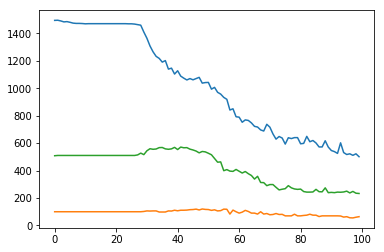

1


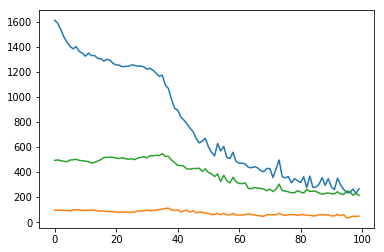

2


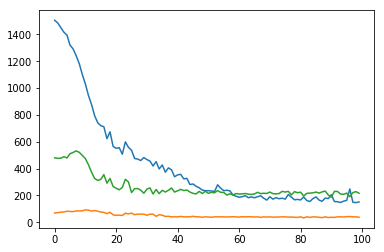

3


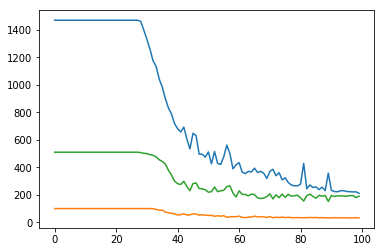

4


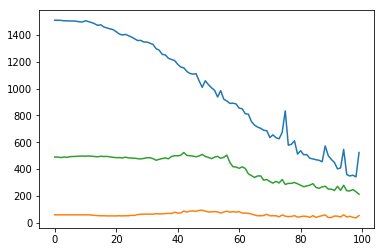

5


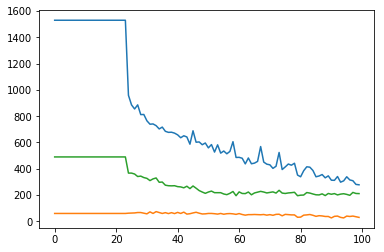

6


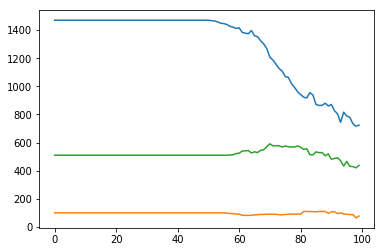

7


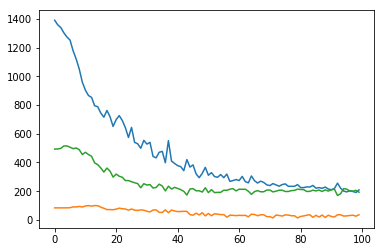

8


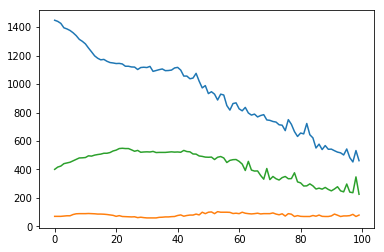

9


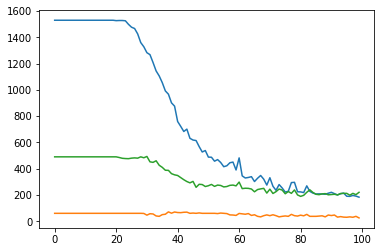

In [6]:
print(train_errors.shape)

for i_rep in range(Nrep):
    print(i_rep)
    plt.plot(np.array(train_errors[i_rep, :]))
    plt.plot(np.array(validation_errors[i_rep, :]))
    plt.plot(np.array(test_errors[i_rep, :]))
    plt.show()

0


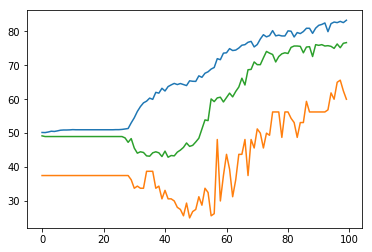

1


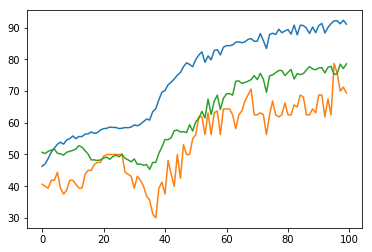

2


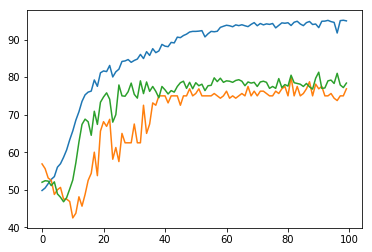

3


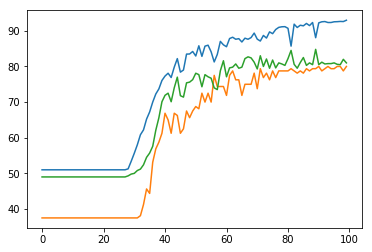

4


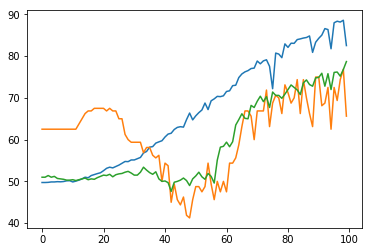

5


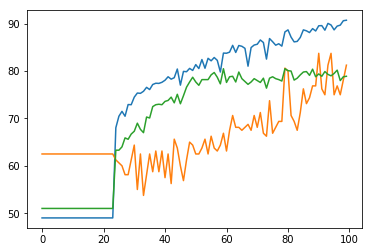

6


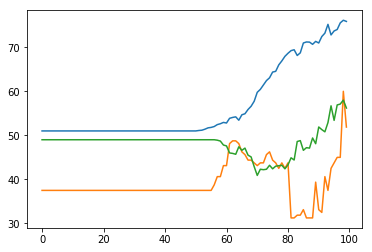

7


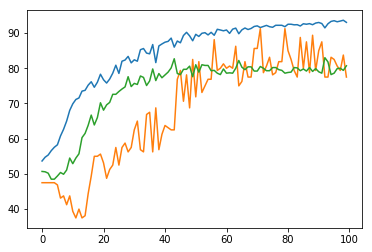

8


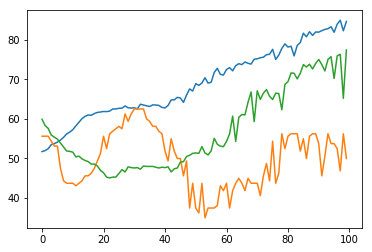

9


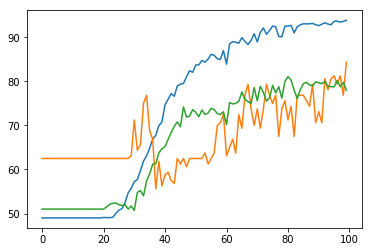

In [7]:
for i_rep in range(Nrep):
    print(i_rep)
    plt.plot(100*(Ntrain-np.array(train_errors[i_rep, :]))/Ntrain)
    plt.plot(100*(Nvalidation-np.array(validation_errors[i_rep, :]))/Nvalidation)
    plt.plot(100*(Ntest-np.array(test_errors[i_rep, :]))/Ntest)

    plt.show()

(100,)
Training accuracy 88.3%+-6.0023322105407715
Validation accuracy 69.7%+-11.763456344604492
Testing accuracy 76.5%+-6.867924690246582


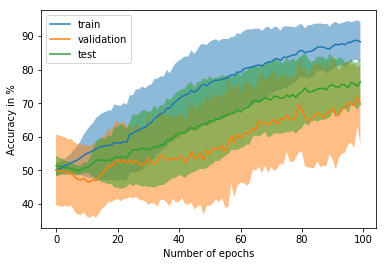

In [8]:
train_accuracy = 100*(Ntrain-np.array(train_errors))/Ntrain
val_accuracy = 100*(Nvalidation-np.array(validation_errors))/Nvalidation
test_accuracy = 100*(Ntest-np.array(test_errors))/Ntest

stddev_train_errors = np.std(train_accuracy, axis=0)
stddev_val_errors = np.std(val_accuracy, axis=0)
stddev_test_errors = np.std(test_accuracy, axis=0)

mean_train_errors = np.mean(train_accuracy, axis=0)
mean_val_errors = np.mean(val_accuracy, axis=0)
mean_test_errors = np.mean(test_accuracy, axis=0)

epoch = list(range(100))
print(stddev_train_errors.shape)

#plt.errorbar(epoch, mean_train_errors, stddev_train_errors)
#plt.errorbar(epoch, mean_val_errors, stddev_val_errors)
#plt.errorbar(epoch, mean_test_errors, stddev_test_errors)

plt.plot(epoch, mean_train_errors)
plt.plot(epoch, mean_val_errors)
plt.plot(epoch, mean_test_errors)
plt.fill_between(epoch, mean_train_errors+stddev_train_errors, mean_train_errors-stddev_train_errors, alpha=0.5)
plt.fill_between(epoch, mean_val_errors+stddev_val_errors, mean_val_errors-stddev_val_errors, alpha=0.5)
plt.fill_between(epoch, mean_test_errors+stddev_test_errors, mean_test_errors-stddev_test_errors, alpha=0.5)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy in %')
plt.legend(['train', 'validation', 'test'])

print("Training accuracy {:4.3g}%+-{}".format(mean_train_errors[-1], stddev_train_errors[-1]))
print("Validation accuracy {:4.3g}%+-{}".format(mean_val_errors[-1], stddev_val_errors[-1]))
print("Testing accuracy {:4.3g}%+-{}".format(mean_test_errors[-1], stddev_test_errors[-1]))